# Кластеризация

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
import inspect
import random
from abc import ABC
from typing import Callable, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from PIL import Image
from sklearn.datasets import make_blobs, make_moons
from sklearn.neighbors import KDTree

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)


# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)
def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")


SEED = 0xC0FFEE
set_seed(SEED)

In [3]:
def visualize_clusters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()


def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter(
            [p[first_color] for p in flatten_image],
            [p[second_color] for p in flatten_image],
            c=flatten_image,
            marker=".",
        )
        axes_pair[1].scatter(
            [p[first_color] for p in flatten_image],
            [p[second_color] for p in flatten_image],
            c=[cluster_colors[c] for c in cluster_labels],
            marker=".",
        )
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

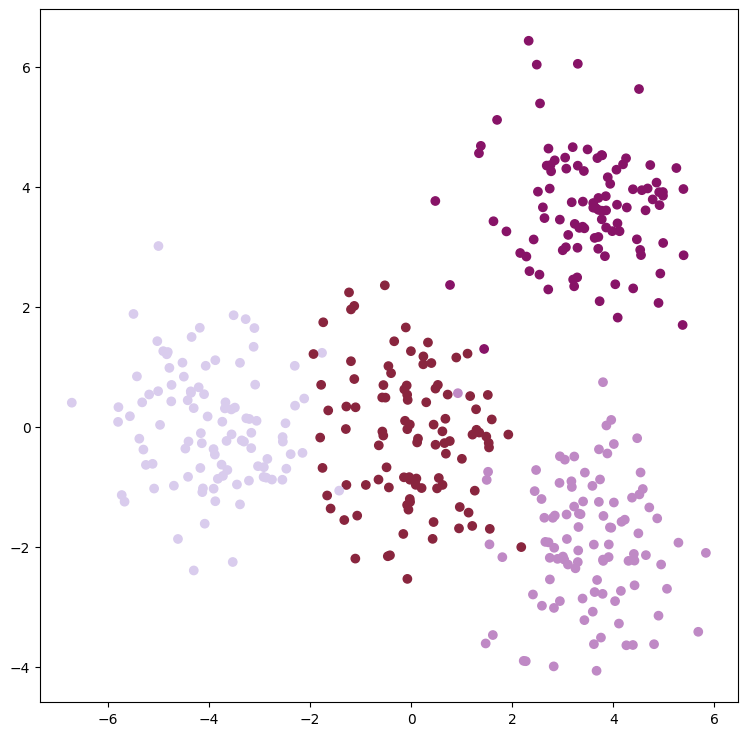

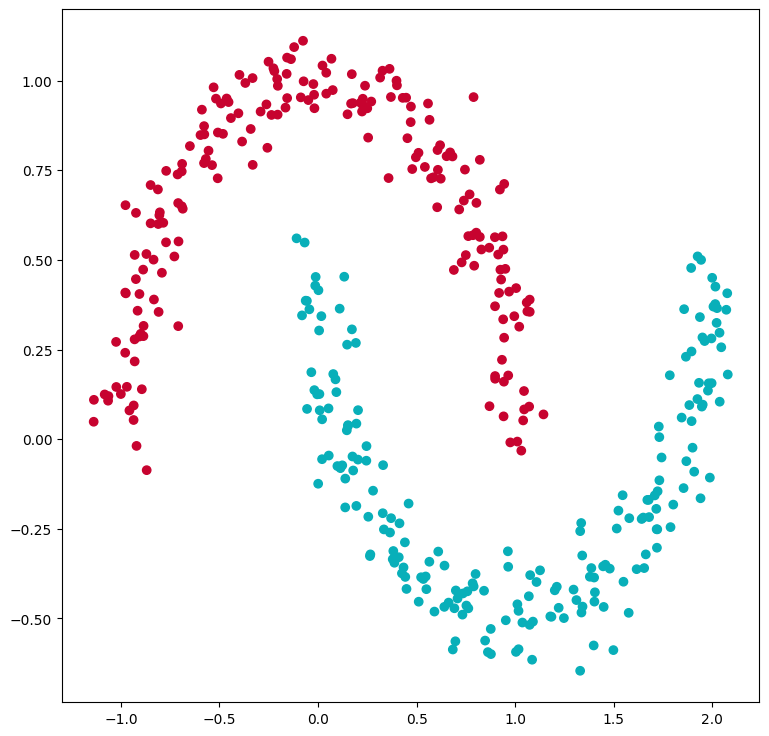

In [4]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clusters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clusters(X_2, true_labels)

Также реализуем необходимые функции для вычисления расстояний между точками

In [5]:
def get_euclidean_distances(from_points: ndarray, to_points: ndarray) -> ndarray:
    """Calculate euclidian distance between points

    Args:
        from_points: array of [source_points; dim] points
        to_points: array of [target_points; dim] points

    Returns:
        distances: array of [source_points; target_points]
    """

    if from_points.ndim == 1:
        from_points = from_points.reshape(1, -1)
    if to_points.ndim == 1:
        to_points = to_points.reshape(1, -1)
        
    return np.sqrt(np.sum((from_points[:, np.newaxis] - to_points) ** 2, axis=2))


def get_manhattan_distances(from_points: ndarray, to_points: ndarray) -> ndarray:
    """Calculate manhattan distance between points

    Args:
        from_points: array of [source_points; dim] points
        to_points: array of [target_points; dim] points

    Returns:
        distances: array of [source_points; target_points]
    """
    if from_points.ndim == 1:
        from_points = from_points.reshape(1, -1)
    if to_points.ndim == 1:
        to_points = to_points.reshape(1, -1)

    diff = np.abs(from_points[:, None, :] - to_points[None, :, :])
    return np.sum(diff, axis=2)


def get_chebyshev_distance(from_points: ndarray, to_points: ndarray) -> ndarray:
    """Calculate chebyshev distance between points

    Args:
        from_points: array of [source_points; dim] points
        to_points: array of [target_points; dim] points

    Returns:
        distances: array of [source_points; target_points]
    """
    if from_points.ndim == 1:
        from_points = from_points.reshape(1, -1)
    if to_points.ndim == 1:
        to_points = to_points.reshape(1, -1)
        
    diff = np.abs(from_points[:, None, :] - to_points[None, :, :])
    return np.max(diff, axis=2)

## K-Means (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

**Описание методов**

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.

`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

Не забудьте реинициализировать пустые кластеры!

In [6]:
class AbstractCentroidBuilder(ABC):
    name: str = None

    def _generate_centroids(self, x: ndarray, k: int) -> ndarray:
        """Generating centroids from points

        Args:
            x: array of [n_points; dim] points
            k: number of centroids to generate

        """
        raise NotImplementedError()

    @staticmethod
    def _validate_centroids(x: ndarray, centroids: ndarray) -> bool:
        """Validating that each centroid has at least one point next to it"""
        closest_centroids = []
        for point in x:
            distances = [np.linalg.norm(point - centroid) for centroid in centroids]
            closest_centroids.append(int(np.argmin(distances)))
        
        counts = np.bincount(closest_centroids, minlength=len(centroids))
        return np.all(counts > 0)

    def build(self, x: ndarray, k: int) -> ndarray:
        max_attempts = min(10*k + 100, 1000)
        for attempt in range(max_attempts):
            centroids = self._generate_centroids(x, k)
            if self._validate_centroids(x, centroids):
                return centroids
        raise RuntimeError("Error generate")

class RandomCentroidBuilder(AbstractCentroidBuilder):
    name: str = "random"

    def _generate_centroids(self, x: ndarray, k: int) -> ndarray:
        min_vals = np.min(x, axis=0)
        max_vals = np.max(x, axis=0)
        return np.random.uniform(min_vals, max_vals, size=(k, x.shape[1]))


class SampleCentroidBuilder(AbstractCentroidBuilder):
    name: str = "sample"

    def _generate_centroids(self, x: ndarray, k: int) -> ndarray:
        indices = np.random.choice(x.shape[0], k, replace=False)
        return x[indices]


class KMeansPlusCentroidBuilder(AbstractCentroidBuilder):
    name: str = "kmeans++"

    def _generate_centroids(self, x: ndarray, k: int) -> ndarray:
        centroids = np.zeros((k, x.shape[1]))
        centroids[0] = x[np.random.choice(x.shape[0])]

        for i in range (1, k):
            distances = np.min(get_euclidean_distances(x, centroids[:i]), axis=1)
            prob = distances ** 2
            prob /= prob.sum()
            centroids[i] = x[np.random.choice(x.shape[0], p=prob)]
        
        return centroids

In [7]:
np.min(np.array([[1, 2], [3, 4], [7, 6]]), axis=1) ** 2

array([ 1,  9, 36])

In [8]:
class KMeans:
    _known_centroid_builders: Dict[str, AbstractCentroidBuilder.__class__] = {
        RandomCentroidBuilder.name: RandomCentroidBuilder,
        SampleCentroidBuilder.name: SampleCentroidBuilder,
        KMeansPlusCentroidBuilder.name: KMeansPlusCentroidBuilder,
    }

    _centroids: ndarray = None
    _x: ndarray = None
    _clusters_ids: ndarray = None

    def __init__(self, n_clusters: int, init: str = "random", max_iter: int = 300):
        """KMeans clusterization

        Args:
            n_clusters: number of clusters
            init: strategy to initialize clusters, one of "random", "sample", and "k-means++"
            max_iter: maximum number of iterations
        """
        self._n_clusters = n_clusters
        self._max_iter = max_iter
        if init not in self._known_centroid_builders:
            raise ValueError(f"Unknown way to initialize clusters centroids: {init}")
        self._centroid_builder = self._known_centroid_builders[init]()

    def fit(self, x: ndarray, y: ndarray = None):
        """Build centroids based on X

        Args:
            x: input points, array of [n_points; dim]
            y: ignored, to mactch sklearn behaviour
        """
        self._centroids = self._centroid_builder.build(x, self._n_clusters)

        for _ in range(self._max_iter):
            distances = get_euclidean_distances(x, self._centroids)
            labels = np.argmin(distances, axis=1)

            new_centroids = []
            for i in range(self._n_clusters):
                cluster_points = x[labels == i]
                if len(cluster_points) == 0:
                    if isinstance(self._centroid_builder, KMeansPlusCentroidBuilder):
                        dists = np.min(get_euclidean_distances(x, self._centroids), axis=1)
                        probs = (dists ** 2) / np.sum(dists ** 2)
                        new_centroid = x[np.random.choice(x.shape[0], p=probs)]
                    else:
                        new_centroid = x[np.random.choice(x.shape[0])]
                    new_centroids.append(new_centroid)
                else:
                    new_centroids.append(cluster_points.mean(axis=0))
            if np.allclose(self._centroids, new_centroids):
                break
            self._centroids = np.array(new_centroids)

    def predict(self, x: np.array) -> np.array:
        """For each element of input returns corresponding cluster index

        Args:
            x: input points, array of [n_points; dim]

        Return
            labels: cluster ids, array of [n_points]
        """
        if self._centroids is None:
            raise RuntimeError("Fit estimator before predicting")
        distances = get_euclidean_distances(x, self._centroids)
        return np.argmin(distances, axis=1)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

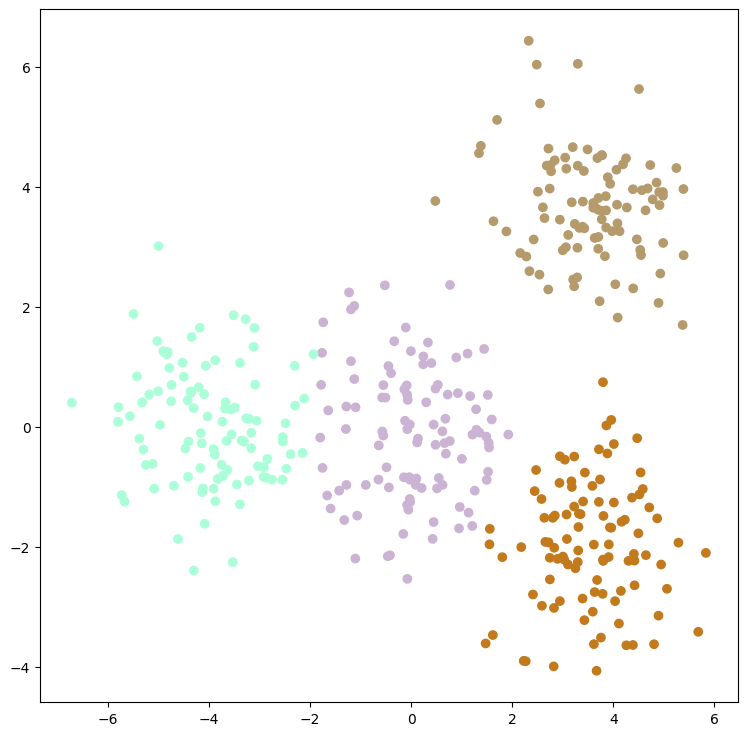

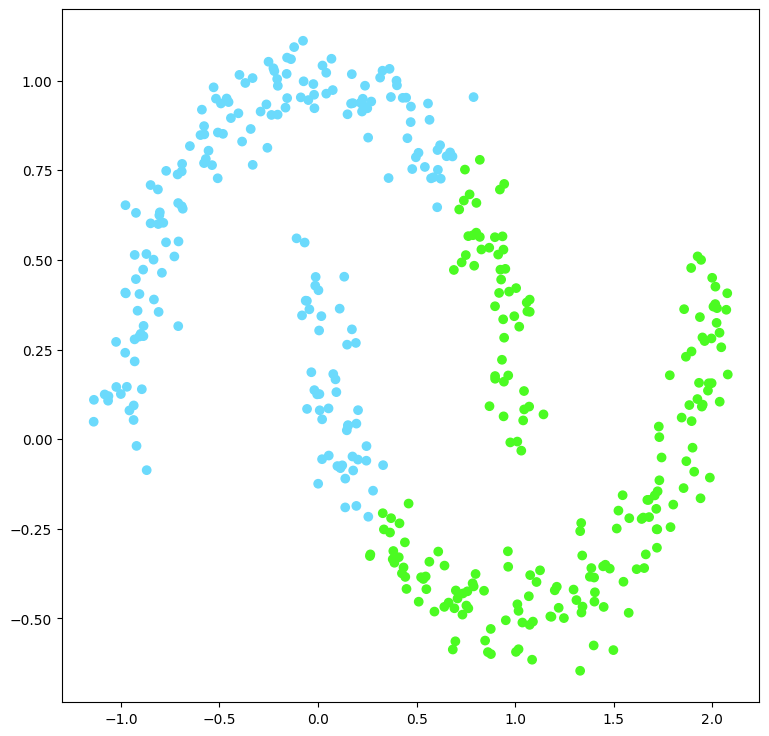

In [9]:
kmeans = KMeans(n_clusters=4, init="kmeans++", max_iter=500)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clusters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="kmeans++", max_iter=500)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clusters(X_2, labels)

## DBScan (3 балла)
В отличие от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

**Описание методов**

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

**Возможные метрики**

`euclidean`, `manhattan`, `chebyshev`

Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`

In [10]:
class DBScan:
    _known_metric_functions: Dict[str, Callable] = {
        "euclidean": get_euclidean_distances,
        "manhattan": get_manhattan_distances,
        "chebyshev": get_chebyshev_distance,
    }

    def __init__(self, eps: float = 0.5, min_samples: int = 5, leaf_size: int = 40, metric: str = "euclidean"):
        """DBScan clusterization

        Args:
            eps, min_samples: parameters for selecting core samples.
                Core samples is a samples with at least `min_samples` samples in their `eps`-neighborhood
            metric: metric to use to calculate distance between samples, one of "euclidian", "manhattan", "chebyshev"
            leaf_size: minimum leaf size for KDTree.
        """

        self._eps = eps
        self._min_samples = min_samples
        if metric not in self._known_metric_functions:
            raise ValueError(f"Unknown metric function: {metric}")
        self._metric = metric
        self._get_distance = self._known_metric_functions[metric]
        self._kdtree_leaf_size = leaf_size

    def fit_predict(self, x: ndarray, y=None) -> ndarray:
        """Cluterize and return index for each point in x

        Args:
            x: input points, array of [n_points; dim]
            y: ignored, to mactch sklearn behaviour
        Return
            labels: cluster ids, array of [n_points]
        """
        tree = KDTree(x, leaf_size=self._kdtree_leaf_size, metric=self._metric)
        neighbors = tree.query_radius(x, r=self._eps)
        core_mask = np.array([len(n) >= self._min_samples for n in neighbors])

        labels = np.full(x.shape[0], -1, dtype=int)
        cluster_id = 0

        for i in range(x.shape[0]):
            if not core_mask[i] or labels[i] != -1:
                continue

            labels[i] = cluster_id
            queue = [i]

            while queue:
                current = queue.pop(0)
                for neighbor in neighbors[current]:
                    if labels[neighbor] == -1:
                        labels[neighbor] = cluster_id
                        if core_mask[neighbor]:
                            queue.append(neighbor)

            cluster_id += 1
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

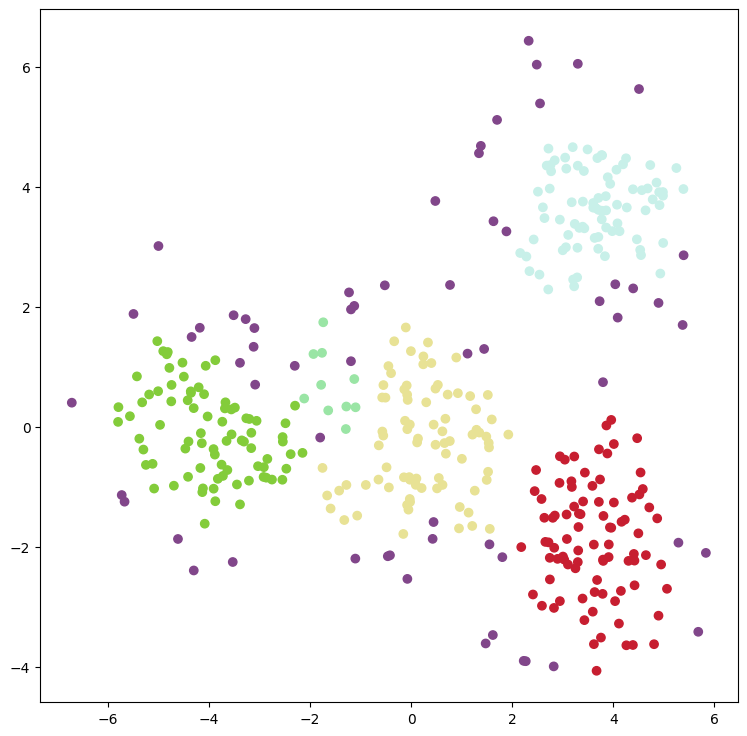

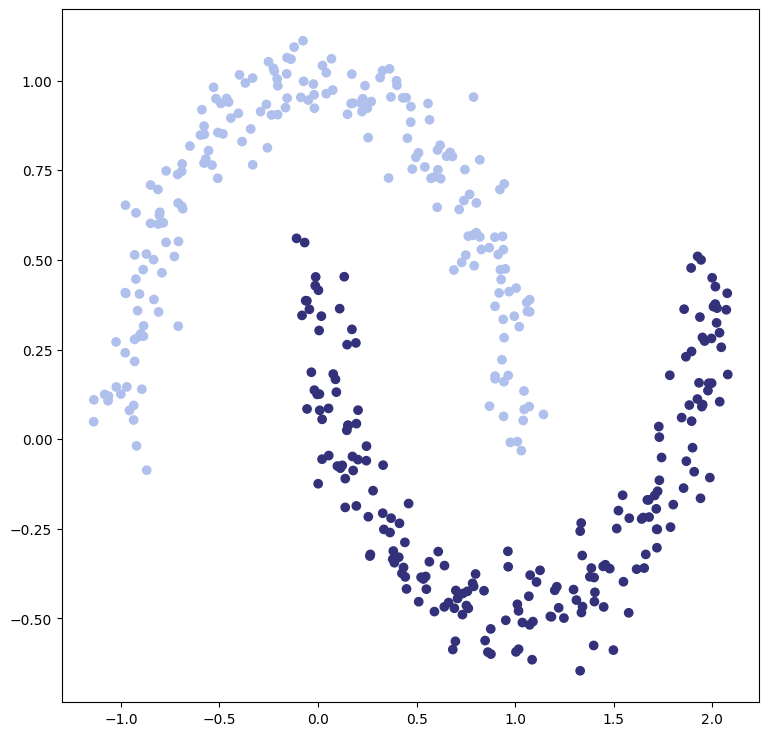

In [49]:
dbscan = DBScan(eps=0.6, min_samples=4, metric='manhattan')
labels = dbscan.fit_predict(X_1)
visualize_clusters(X_1, labels)

dbscan = DBScan(eps=0.2, min_samples=2, metric='euclidean')
labels = dbscan.fit_predict(X_2)
visualize_clusters(X_2, labels)

## Agglomerative Clustering (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

**Описание методов**

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

### Linkage
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

Для быстрого вычисления воспользуемся формулой Ланса-Уильямса

$$
D(W, S) = \alpha_U D(U, S) + \alpha_V D(V, S) + \beta D(U, V) + \gamma \left| D(U, S) - D(V, S) \right|
$$


| Метод агломерации         | α<sub>U</sub>                             | α<sub>V</sub>                             | β                                       | γ       |
|--------------------------|------------------------------------------|------------------------------------------|-----------------------------------------|----------|
| Single linkage           | 0.5                                      | 0.5                                      | 0                                       | -0.5     |
| Complete linkage         | 0.5                                      | 0.5                                      | 0                                       | +0.5     |
| Average linkage          | n<sub>U</sub> / (n<sub>U</sub> + n<sub>V</sub>) | n<sub>V</sub> / (n<sub>U</sub> + n<sub>V</sub>) | 0                                       | 0        |
| Centroid linkage         | n<sub>U</sub> / (n<sub>U</sub> + n<sub>V</sub>) | n<sub>V</sub> / (n<sub>U</sub> + n<sub>V</sub>) | -n<sub>U</sub>n<sub>V</sub> / (n<sub>U</sub> + n<sub>V</sub>)² | 0        |
| Ward's method            | (n<sub>S</sub> + n<sub>U</sub>) / (n<sub>S</sub> + n<sub>U</sub> + n<sub>V</sub>) | (n<sub>S</sub> + n<sub>V</sub>) / (n<sub>S</sub> + n<sub>U</sub> + n<sub>V</sub>) | -n<sub>S</sub> / (n<sub>S</sub> + n<sub>U</sub> + n<sub>V</sub>) | 0        |

In [12]:
# Return coefficients based on Lance–Williams formula for different linkages


def get_average_linkage_params(u_size: int, v_size: int) -> Tuple[float, float, float, float]:
    total = u_size + v_size
    return (u_size/total, v_size/total, 0.0, 0.0)


def get_single_linkage_params(u_size: int, v_size: int) -> Tuple[float, float, float, float]:
    return (0.5, 0.5, 0.0, -0.5)


def get_complete_linkage_params(u_size: int, v_size: int) -> Tuple[float, float, float, float]:
    return (0.5, 0.5, 0.0, 0.5)

In [13]:
class AgglomerativeClustering:

    _known_linkages = {
        "average": get_average_linkage_params,
        "single": get_single_linkage_params,
        "complete": get_complete_linkage_params,
    }

    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """Agglomerative clusterization

        Args:
            n_clusters: number of clusters
            linkage: linkage to use, one of "average", "single", and "complete"
        """
        self._n_clusters = n_clusters
        if linkage not in self._known_linkages:
            raise ValueError(f"Unknown linkage: {linkage}")
        self._linkage = self._known_linkages[linkage]

    def fit_predict(self, x: ndarray, y=None) -> ndarray:
        """Cluterize and return index for each point in x

        Args:
            x: input points, array of [n_points; dim]
            y: ignored, to mactch sklearn behaviour
        Return
            labels: cluster ids, array of [n_points]
        """
        def get_distance(key):
            return dist_matrix[key]
        
        n = x.shape[0]
        clusters = [[i] for i in range(n)]
        dist_matrix = {}

        for i in range(n):
            for j in range(i+1, n):
                dist_matrix[(i, j)] = np.linalg.norm(x[i] - x[j])
        
        current_clusters = set(range(n))

        while len(current_clusters) > self._n_clusters:
            min_pair = min(dist_matrix, key=get_distance)
            u, v = min_pair
            d_uv = dist_matrix[min_pair]

            w = len(clusters)
            clusters.append(clusters[u] + clusters[v])

            for s in list(current_clusters):
                if s in (u, v):
                    continue

                d_us = dist_matrix.get(tuple(sorted((u, s))), np.inf)
                d_vs = dist_matrix.get(tuple(sorted((v, s))), np.inf)

                a_u, a_v, beta, gamma = self._linkage(len(clusters[u]), len(clusters[v]))

                new_dist = a_u * d_us + a_v * d_vs + beta * d_uv + gamma * abs(d_us - d_vs)
                dist_matrix[tuple(sorted((w, s)))] = new_dist

            key_to_remove = [k for k in dist_matrix if u in k or v in k]
            for k in key_to_remove:
                del dist_matrix[k]

            current_clusters.remove(u)
            current_clusters.remove(v)
            current_clusters.add(w)

        labels = np.empty(n, dtype=int)
        for idx, cluster_id in enumerate(sorted(current_clusters)):
            for sample in clusters[cluster_id]:
                labels[sample] = idx

        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

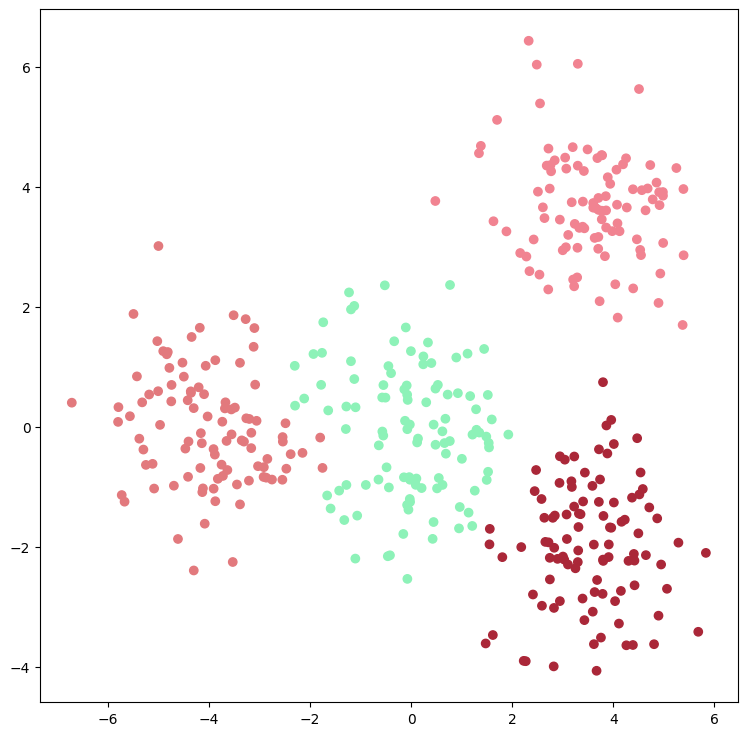

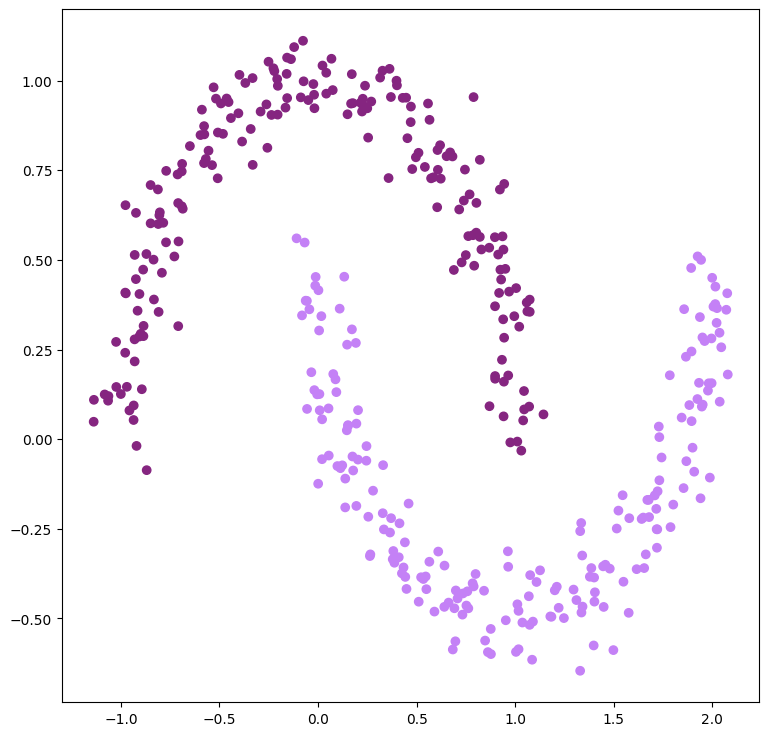

In [14]:
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage="complete")
labels = agg_clustering.fit_predict(X_1)
visualize_clusters(X_1, labels)

agg_clustering = AgglomerativeClustering(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clusters(X_2, labels)

## Сжатие изображений (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки [`Pillow`](https://github.com/python-pillow/Pillow).

Нормализованное изображение - это изображение, у которого все значения пикселей находятся в $[0; 1]$.

In [15]:
def read_image(path: str) -> ndarray:
    """Read and return image from file

    Args:
        path: path to the image file

    Return:
        image: normalized image array of shape [H, W, 3]
    """
    img = Image.open(path)
    return np.array(img) / 255.0


def show_image(image: ndarray):
    """Display the image using matplotlib

    Args:
        image: normalized image array of shape [H, W, 3]
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def save_image(image: ndarray, path: str):
    """Save the image to file

    Args:
        image: normalized image array of shape [H, W, 3]
        path: path to save the image
    """
    img = Image.fromarray((image * 255).astype(np.uint8))
    img.save(path)

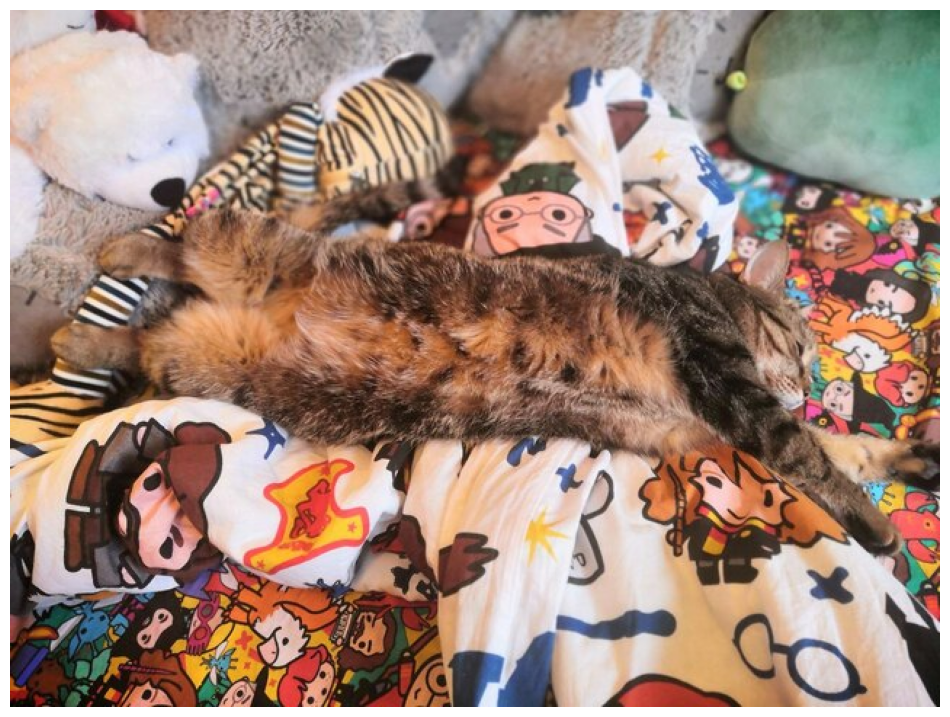

In [46]:
# Put your favorite image and read it


image = read_image("stepan.jpg")
show_image(image)

Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [47]:
def clusterize_image(image: ndarray, n_clusters: int):
    h, w, _ = image.shape
    pixels = image.reshape(-1, 3)

    model = KMeans(n_clusters=n_clusters, init="kmeans++", max_iter=300)
    model.fit(image.reshape(-1, 3))
    cluster_colors = model._centroids
    clusters = model.predict(pixels)
    recolored = cluster_colors[clusters].reshape(image.shape)
    
    clusters_statistics(pixels, cluster_colors, clusters)  # Very slow (:
    recolored = cluster_colors[clusters].reshape(h, w, 3)
    return recolored

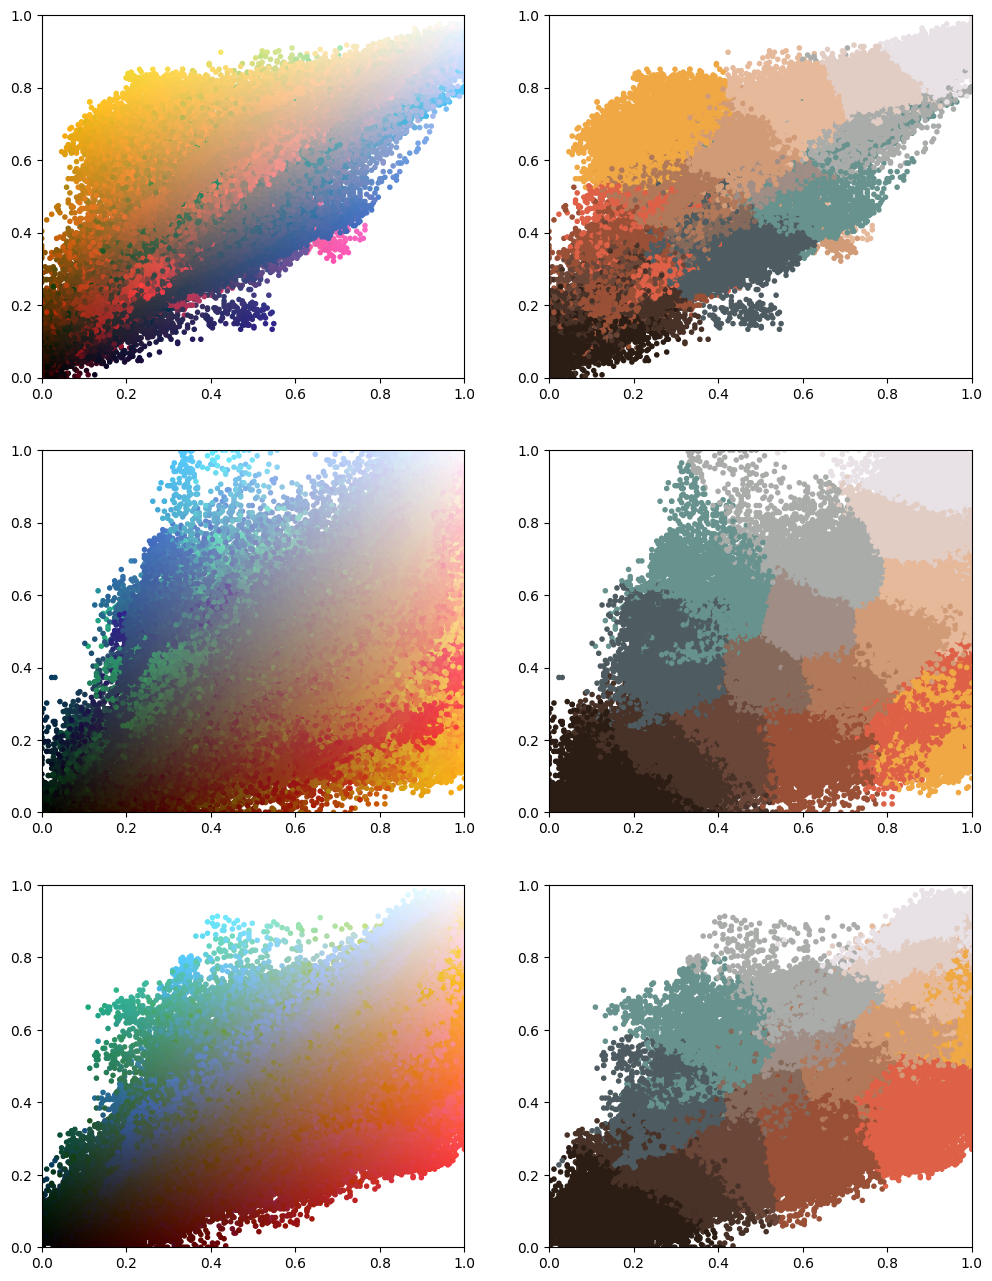

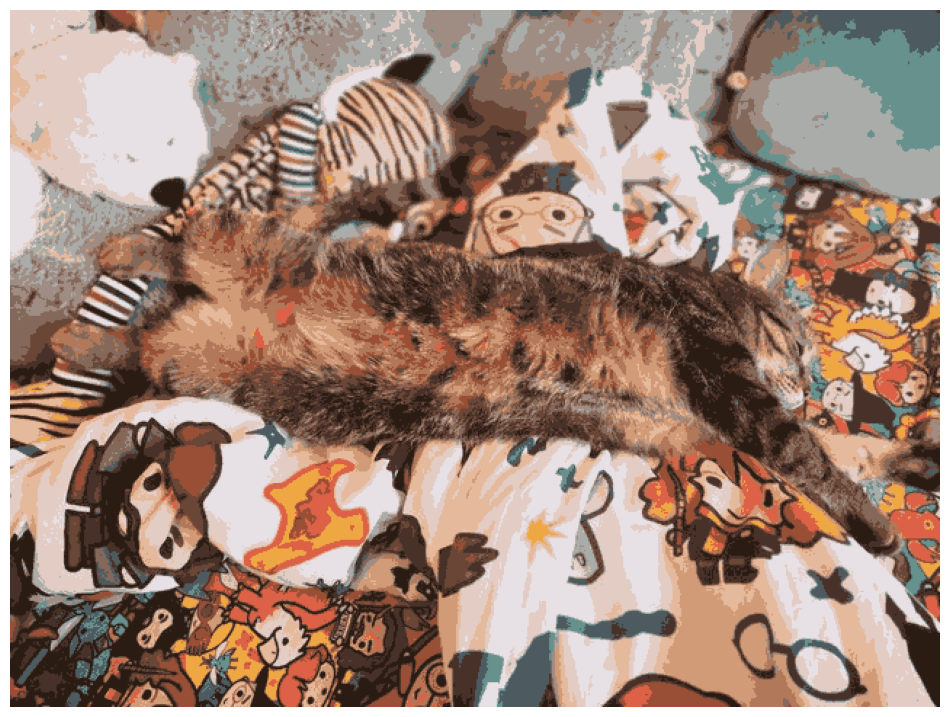

In [48]:
image = read_image("stepan.jpg")
result = clusterize_image(image, n_clusters=16)
show_image(result)
save_image(result, "result.jpg")